In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import tensorflow as tf
session = tf.InteractiveSession()

In [2]:
from exoplanet.tri_diag_solve import tri_diag_solve
from exoplanet.interp import cubic_op

In [3]:
class CubicInterpolator(object):
    
    def __init__(self, x, y, endpoints=None, dtype=tf.float32, name=None):
        with tf.name_scope(name, "CubicInterpolator"):
            x = tf.cast(x, dtype)
            y = tf.cast(y, dtype)

            # Compute the deltas
            size = tf.shape(x)[-1]
            axis = tf.rank(x) - 1
            dx = tf.gather(x, tf.range(1, size), axis=axis) - tf.gather(x, tf.range(size-1), axis=axis)
            dy = tf.gather(y, tf.range(1, size), axis=axis) - tf.gather(y, tf.range(size-1), axis=axis)

            # Compute the slices
            upper_inds = tf.range(1, size-1)
            lower_inds = tf.range(size-2)
            s_up = lambda a: tf.gather(a, upper_inds, axis=axis)
            s_lo = lambda a: tf.gather(a, lower_inds, axis=axis)
            dx_up = s_up(dx)
            dx_lo = s_lo(dx)
            dy_up = s_up(dy)
            dy_lo = s_lo(dy)

            first = lambda a: tf.gather(a, tf.zeros(1, dtype=tf.int64), axis=axis)
            last = lambda a: tf.gather(a, [size-2], axis=axis)

            diag = 2*tf.concat((first(dx), dx_up+dx_lo, last(dx)), axis)
            upper = dx
            lower = dx
            Y = 3*tf.concat((first(dy)/first(dx),
                             dy_up/dx_up - dy_lo/dx_lo,
                             -last(dy)/last(dx)), axis)
            
            # Solve the tri-diagonal system
            c = tri_diag_solve(diag, upper, lower, Y)
            c_up = tf.gather(c, tf.range(1, size), axis=axis)
            c_lo = tf.gather(c, tf.range(size-1), axis=axis)
            b = dy / dx - dx * (c_up + 2*c_lo) / 3
            d = (c_up - c_lo) / (3*dx)
            
            self.x = x
            self.y = y
            self.b = b
            self.c = c_lo
            self.d = d
                
    def evaluate(self, t, name=None):
        with tf.name_scope(name, "evaluate"):
            res = cubic_op.cubic_gather(t, self.x, self.y, self.b, self.c, self.d)
            tau = t - res.xk
            return res.ak + res.bk * tau + res.ck * tau**2 + res.dk * tau**3
#             inds = cubic_op.search_sorted(self.x, t)
            
#             if self._endpoints == "natural":
#                 inds = tf.clip_by_value(inds-1,
#                         tf.constant(0, dtype=tf.int64),
#                         tf.cast(tf.shape(self.x)[-1], tf.int64) - 2)
                
#             inds = tf.stack(tf.meshgrid(
#                 *[tf.range(s, dtype=tf.int64) for s in t.shape], indexing="ij")[:-1]
#                             + [inds], axis=-1)

#             print(tf.gather_nd(self.y_ext, inds).eval())
#             tau = t - tf.gather_nd(self.x_ext, inds)
#             mod = tf.gather_nd(self.y_ext, inds)
#             mod += tau * tf.gather_nd(self.b, inds)
#             mod += tau**2 * tf.gather_nd(self.c, inds)
#             mod += tau**3 * tf.gather_nd(self.d, inds)
            
#             return mod

In [4]:
T = tf.float64

np.random.seed(123)
x = np.sort(np.random.uniform(1, 9, (3, 8)))
# x = np.linspace(1, 9, 80)
y = np.sin(x)
t = np.linspace(0, 10, 500)
t = t + np.zeros((x.shape[0], len(t)))

x_t = tf.constant(x, dtype=T)
y_t = tf.constant(y, dtype=T)
t_t = tf.constant(t, dtype=T)

interp = CubicInterpolator(x_t, y_t, dtype=T)
model = interp.evaluate(t_t)

In [5]:
interp.x.shape

TensorShape([Dimension(3), Dimension(8)])

In [6]:
tf.gradients(model, y_t)

[<tf.Tensor 'gradients/AddN_5:0' shape=(3, 8) dtype=float64>]

In [7]:
res = cubic_op.cubic_gather(t_t, x_t, y_t, interp.b, interp.c, interp.d)
session.run(tf.gradients(res.ak, y_t))

[array([[165.,  54.,  51.,  54.,   4.,  10., 104.,  58.],
        [187.,  20.,   2.,  16.,  17.,  99.,   4., 155.],
        [123., 140.,   0.,  31.,  10.,  36.,  49., 111.]])]

In [8]:
session.run(res)

CubicGather(ak=array([[0.32099607, 0.32099607, 0.32099607, ..., 0.54690625, 0.54690625,
        0.54690625],
       [0.99564389, 0.99564389, 0.99564389, ..., 0.58166813, 0.58166813,
        0.58166813],
       [0.6727938 , 0.6727938 , 0.6727938 , ..., 0.99828777, 0.99828777,
        0.99828777]]), bk=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), ck=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), dk=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), xk=array([[2.81481163, 2.81481163, 2.81481163, ..., 8.84611359, 8.84611359,
        8.84611359],
       [1.47742317, 1.47742317, 1.47742317, ..., 6.90396325, 6.90396325,
        6.90396325],
       [2.40361405, 2.40361405, 2.40361405, ..., 7.79545435, 7.79545435,
        7.79545435]]), inds=array([[-1, -1, -1, ...,  7,  7,  7],
       [-1, -1

In [9]:
tau = t_t - res.xk
model2 = res.ak + res.bk * tau + res.ck * tau**2 + res.dk * tau**3

In [10]:
model.eval() - model2.eval()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

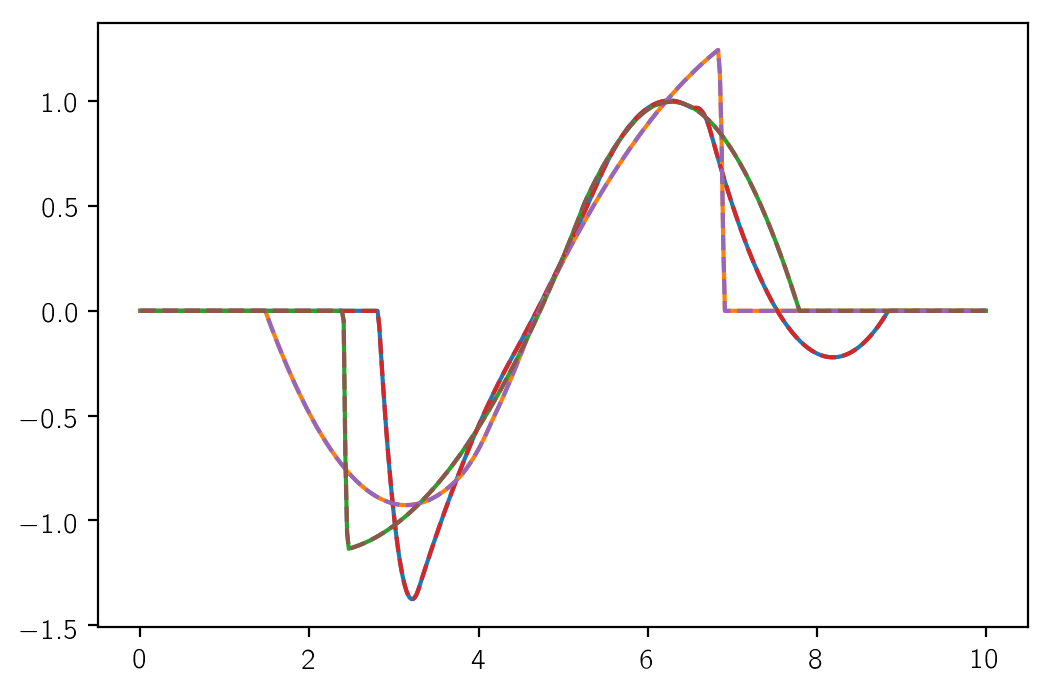

In [11]:
# plt.plot(x.T, y.T, ".")
plt.plot(t.T, session.run(tf.gradients(model2, t_t))[0].T);
plt.plot(t.T, session.run(tf.gradients(model, t_t))[0].T, "--");

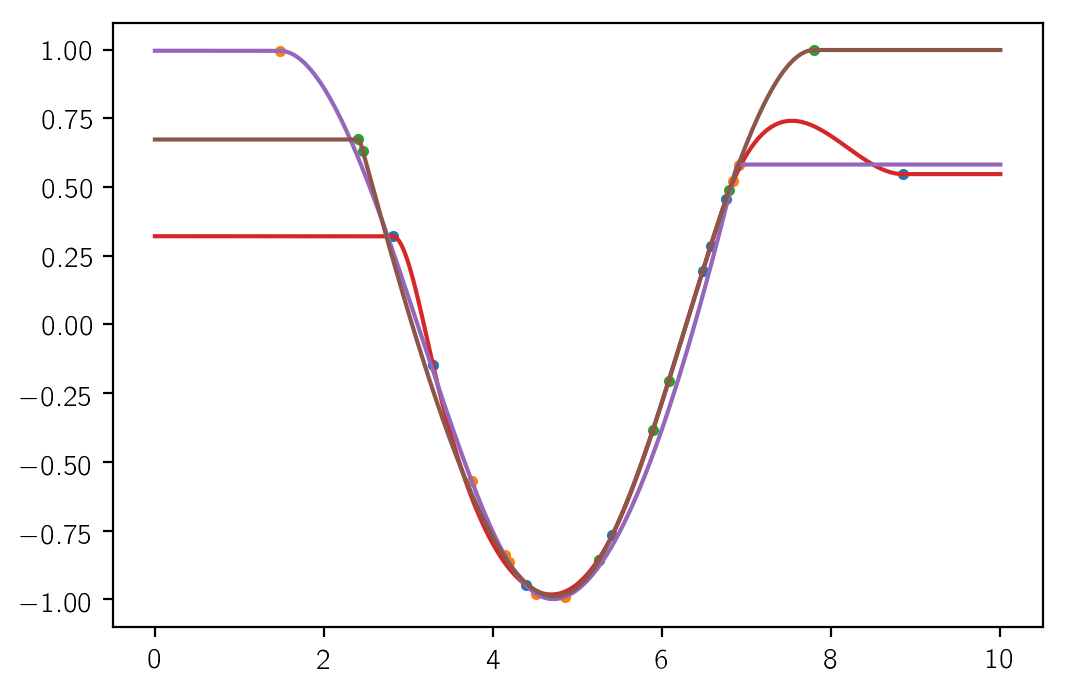

In [11]:
plt.plot(x.T, y.T, ".")
plt.plot(t.T, model.eval().T);

In [12]:
# # http://banach.millersville.edu/~bob/math375/CubicSpline/main.pdf

# T = tf.float64

# np.random.seed(42)
# x = np.sort(np.random.uniform(1, 9, 8))
# # x = np.linspace(1, 9, 80)
# y = np.sin(x/2)
# t = np.linspace(0, 10, 500)

# pa = np.polyfit(x[:3], y[:3], 2)
# pb = np.polyfit(x[-3:], y[-3:], 2)
# fpa = np.polyval(np.polyder(pa), x[0])
# fpb = np.polyval(np.polyder(pb), x[-1])
# print(fpa, fpb)

In [2]:
x_t = tf.constant(x, dtype=T)
y_t = tf.constant(y, dtype=T)
t_t = tf.constant(t, dtype=T)

dx = x_t[1:] - x_t[:-1]
dy = y_t[1:] - y_t[:-1]

fpa_t = tf.constant(0.0, dtype=T)
fpb_t = tf.constant(0.0, dtype=T)

diag = tf.concat((2*dx[:1], 2*(dx[1:]+dx[:-1]), 2*dx[-1:]), 0)
upper = dx
lower = dx
Y = tf.concat((3 * dy[:1]/dx[:1] - 3 * fpa_t,
               3 * (dy[1:]/dx[1:] - dy[:-1]/dx[:-1]),
               3 * fpb_t - 3 * dy[-1:]/dx[-1:]), 0)

# diag = tf.concat((tf.ones(1, dtype=T), 2*(dx[1:]+dx[:-1]), tf.ones(1, dtype=T)), 0)
# upper = tf.concat((tf.zeros(1, dtype=T), dx[1:]), 0)
# lower = tf.concat((dx[:-1], tf.zeros(1, dtype=T)), 0)
# Y = tf.concat((tf.zeros(1, dtype=T),
#                3 * (dy[1:]/dx[1:] - dy[:-1]/dx[:-1]),
#                tf.zeros(1, dtype=T)), 0)

c = tri_diag_solve(diag, upper, lower, Y)
b = dy / dx - dx * (c[1:] + 2*c[:-1]) / 3
d = (c[1:] - c[:-1]) / (3*dx)

b_ext = tf.concat(([fpa_t], b, [fpb_t]), 0)
c_ext = tf.concat((tf.zeros(1, dtype=T), c[:-1], tf.zeros(1, dtype=T)), 0)
d_ext = tf.concat((tf.zeros(1, dtype=T), d, tf.zeros(1, dtype=T)), 0)
x_ext = tf.concat((x_t[:1], x_t), 0)
y_ext = tf.concat((y_t[:1], y_t), 0)

# b_ext = tf.concat((b[:1], b, b[-1:]), 0)
# c_ext = tf.concat((c[:1], c[:-1], c[-2:-1]), 0)
# d_ext = tf.concat((d[:1], d, d[-1:]), 0)
# x_ext = tf.concat((x_t[:1], x_t), 0)
# y_ext = tf.concat((y_t[:1], y_t), 0)

inds = search_sorted_op.search_sorted(x_t, t_t)

# inds = tf.clip_by_value(inds-1,
#                         tf.constant(0, dtype=tf.int64),
#                         tf.cast(tf.size(x_t), tf.int64) - 2)
# b_ext = b
# c_ext = c
# d_ext = d
# x_ext = x_t
# y_ext = y_t

tau = t_t - tf.gather(x_ext, inds)
mod = tf.gather(y_ext, inds)
mod += tau * tf.gather(b_ext, inds)
mod += tau**2 * tf.gather(c_ext, inds)
mod += tau**3 * tf.gather(d_ext, inds)

NameError: name 'tf' is not defined

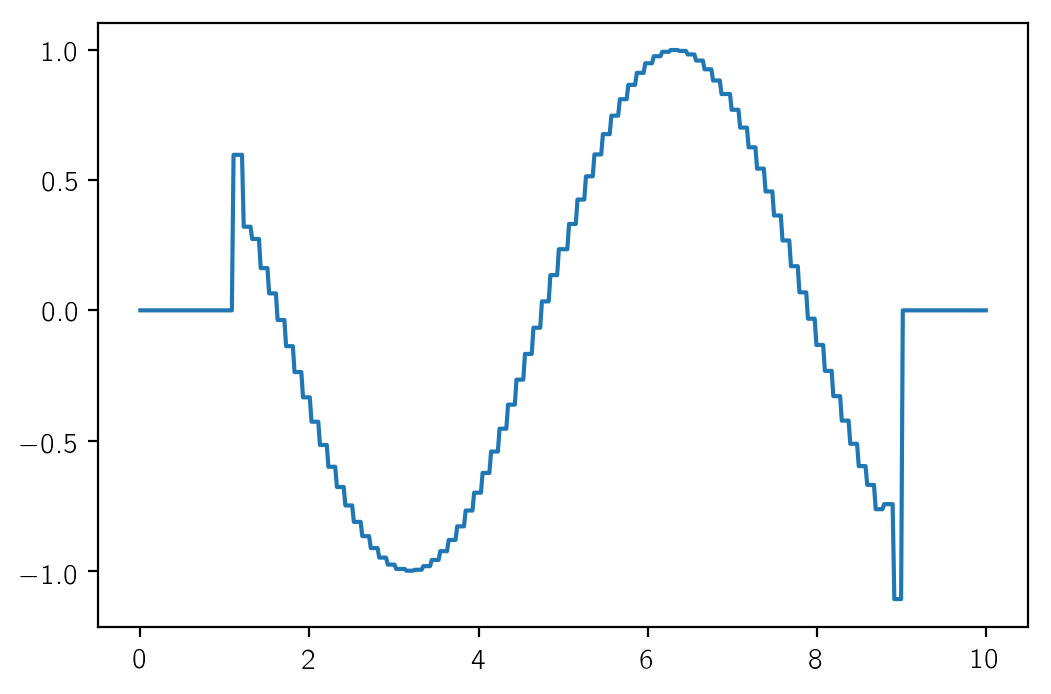

In [27]:
plt.plot(t, tf.gather(b_ext, inds).eval())

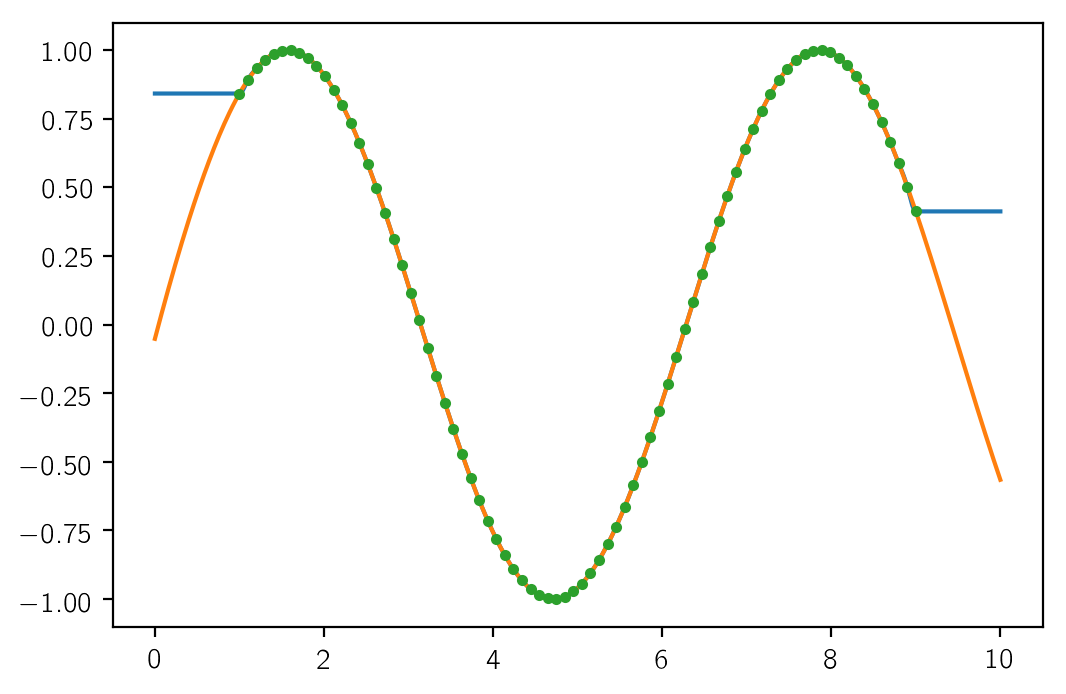

In [28]:
plt.plot(t, mod.eval())
plt.plot(t, interp1d(x, y, kind="cubic", fill_value="extrapolate")(t))
plt.plot(x, y, ".")

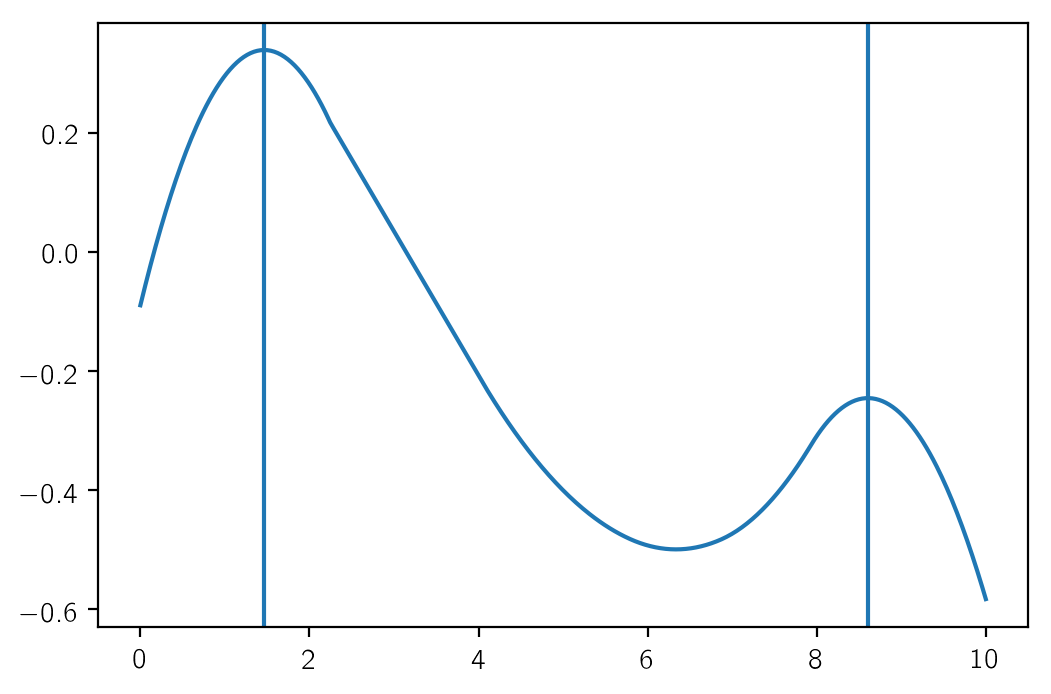

In [273]:
plt.plot(t, session.run(tf.gradients(mod, t_t)[0]))
plt.axvline(x[0])
plt.axvline(x[-1])

In [35]:
def step1(dx, dy):
    n = len(dx)
    np1 = n + 1
    
    a = np.empty(np1)
    a[0] = 3 * dy[0] / dx[0]
    a[1:-1] = 3 * dy[1:] / dx[1:] - 3 * dy[:-1] / dx[:-1]
    a[-1] = -3 * dy[-1] / dx[-1]
    
    return a

def step1_rev(dx, dy, a, ba):
    bdx = np.zeros_like(dx)
    bdy = np.zeros_like(dy)
    
    # a[0] = 3 * dy[0] / dx[0]
    bdy[0] += 3 * ba[0] / dx[0]
    bdx[0] += -a[0] * ba[0] / dx[0]

    # a[1:-1] = 3 * dy[1:] / dx[1:] - 3 * dy[:-1] / dx[:-1]
    bdy[1:] += 3 * ba[1:-1] / dx[1:]
    bdy[:-1] += -3 * ba[1:-1] / dx[:-1]
    bdx[1:] += -3 * dy[1:] * ba[1:-1] / dx[1:]**2
    bdx[:-1] += 3 * dy[:-1] * ba[1:-1] / dx[:-1]**2

    # a[-1] = -3 * dy[-1] / dx[-1]
    bdy[-1] += -3 * ba[-1] / dx[-1]
    bdx[-1] += -a[-1] * ba[-1] / dx[-1]
    
    return bdx, bdy

def step2(dx, a):
    n = len(dx)
    np1 = n + 1

    l = np.empty(np1)
    u = np.empty(n)
    z = np.empty(np1)
    l[0] = 2*dx[0]
    u[0] = 0.5
    z[0] = a[0] / l[0]
    for i in range(1, n):
        l[i] = 2*dx[i] + dx[i-1] * (2 - u[i-1])
        u[i] = dx[i] / l[i]
        z[i] = (a[i] - dx[i-1] * z[i-1]) / l[i]
    l[-1] = dx[-1] * (2 - u[-1])
    z[-1] = (a[-1] - dx[-1] * z[-2]) / l[-1]
    
    return u, l, z

def step2_rev(dx, a, u, l, z, bu, bl, bz):
    n = len(u)
    
    bu = np.array(bu)
    bl = np.array(bl)
    bz = np.array(bz)

    ba = np.zeros_like(a)
    bdx = np.zeros_like(dx)

    # z[-1] = (a[-1] - dx[-1] * z[-2]) / l[-1]
    ba[-1] += bz[-1] / l[-1]
    bdx[-1] += -z[-2] * bz[-1] / l[-1]
    bz[-2] += -dx[-1] * bz[-1] / l[-1]
    bl[-1] += -z[-1] * bz[-1] / l[-1]
    
    # l[-1] = dx[-1] * (2 - u[-1])
    bdx[-1] += (2 - u[-1]) * bl[-1]
    bu[-1] += -dx[-1] * bl[-1]

    # for i in range(1, n):
    for i in range(n-1, 0, -1):
        # z[i] = (a[i] - dx[i-1] * z[i-1]) / l[i]
        ba[i] += bz[i] / l[i]
        bl[i] += -z[i]*bz[i]/l[i]
        bdx[i-1] += -z[i-1] * bz[i] / l[i]
        bz[i-1] += -bz[i] * dx[i-1] / l[i]
        
        # u[i] = dx[i] / l[i]
        bdx[i] += bu[i] / l[i]
        bl[i] += -bu[i]*u[i]/l[i]

        # l[i] = 2*dx[i] + dx[i-1] * (2 - u[i-1])
        bdx[i] += 2*bl[i]
        bdx[i-1] += (2-u[i-1])*bl[i]
        bu[i-1] += -dx[i-1] * bl[i]
        
    # z[0] = a[0] / l[0]
    ba[0] += bz[0] / l[0]
    bl[0] += -z[0] * bz[0] / l[0]

    # l[0] = 2*dx[0]
    bdx[0] += 2*bl[0]
    return bdx, ba

def step3(z, u):
    n = len(u)
    c = np.empty_like(z)
    c[-1] = z[-1]
    for j in range(n-1, -1, -1):
        c[j] = z[j] - u[j] * c[j+1]
    return c

def step3_rev(z, u, c, bc):
    n = len(u)
    bc = np.array(bc)
    bu = np.zeros_like(u)
    bz = np.zeros_like(z)
    # for j in range(n-1, -1, -1):
    for j in range(n):
        # c[j] = z[j] - u[j] * c[j+1]
        bz[j] += bc[j]
        bc[j+1] += -bc[j] * u[j]
        bu[j] += -c[j+1] * bc[j]
    # c[-1] = z[-1]
    bz[-1] += bc[-1]
    return bz, bu

def step4(dx, dy, c):
    b = dy / dx - dx * (c[1:] + 2*c[:-1]) / 3
    d = (c[1:] - c[:-1]) / (3*dx)
    return b, d

def step4_rev(dx, dy, c, b, d, bb, bd):
    bc = np.zeros_like(c)
    
    # d = (c[1:] - c[:-1]) / (3*dx)
    bdx = -d * bd / dx
    bc[1:] += bd / (3*dx)
    bc[:-1] += -bd / (3*dx)
    
    # b = dy / dx - dx * (c[1:] + 2*c[:-1]) / 3
    bdy = bb / dx
    bdx += -(dy/dx**2 + (c[1:]+2*c[:-1])/3) * bb
    bc[1:] += -dx * bb / 3
    bc[:-1] += -2 * dx * bb / 3

    return bdx, bdy, bc

def compute_polys(dx, dy):
    n = len(dx)
    np1 = n + 1
    
    # Step 1
    a = step1(dx, dy)
    
    # Step 2
    u, l, z = step2(dx, a)
    
    # Step 3
    c = step3(z, u)    
    
    # Step 4
    b, d = step4(dx, dy, c)
    
    return (np.vstack((
        np.concatenate(([0.0], b, [0.0])),
        np.concatenate(([0.0], c[:-1], [0.0])),
        np.concatenate(([0.0], d, [0.0]))
    )).T, a, z, u, l)

def compute_polys_rev(dx, dy, P, a, z, u, l, bP):
    n = len(dx)
    np1 = n + 1

    b = P[1:-1, 0]
    c = P[1:, 1]
    d = P[1:-1, 2]
    
    bb = np.array(bP[1:-1, 0])
    bc = np.array(bP[1:, 1])
    bd = np.array(bP[1:-1, 2])
    bc[-1] = 0.0
    
    # Step 4
    bdx, bdy, bc0 = step4_rev(dx, dy, c, b, d, bb, bd)
    bc += bc0
    
    # Step 3
    bz, bu = step3_rev(z, u, c, bc)
    
    # Step 2
    bl = np.zeros_like(l)
    bdx0, ba = step2_rev(dx, a, u, l, z, bu, bl, bz)
    bdx += bdx0
    
    # Step 1
    bdx0, bdy0 = step1_rev(dx, dy, a, ba)
    bdx += bdx0
    bdy += bdy0
    
    return bdx, bdy

In [39]:
def check_grad(value, grad, f, args=None, eps=1e-8, ind=None, factor=None):
    if args is None:
        args = (value,)
    if factor is None:
        factor = 1.0
    for i in range(len(value)):
        value[i] += eps
        r = f(*args)
        if ind is None:
            vp = np.sum(factor*r)
        else:
            vp = np.sum(factor*r[ind])

        value[i] -= 2*eps
        r = f(*args)
        if ind is None:
            vm = np.sum(factor*r)
        else:
            vm = np.sum(factor*r[ind])
        value[i] += eps

        est = 0.5 * (vp - vm) / eps
        print(est, grad[i], est - grad[i])

In [40]:
n = 5
dx = np.random.rand(n)
dy = np.random.randn(n)
c = np.random.randn(n+1)
b, d = step4(dx, dy, c)

bb = np.random.randn(len(b))
bd = np.zeros_like(d)
bdx, bdy, bc = step4_rev(dx, dy, c, b, d, bb, bd)

print("b, dx:")
check_grad(dx, bdx, step4, args=(dx, dy, c), ind=0, factor=bb)
print("b, dy:")
check_grad(dy, bdy, step4, args=(dx, dy, c), ind=0, factor=bb)
print("b, c:")
check_grad(c, bc, step4, args=(dx, dy, c), ind=0, factor=bb)

bb = np.zeros_like(b)
bd = np.random.randn(len(d))
bdx, bdy, bc = step4_rev(dx, dy, c, b, d, bb, bd)

print("d, dx:")
check_grad(dx, bdx, step4, args=(dx, dy, c), ind=1, factor=bd)
print("d, dy:")
check_grad(dy, bdy, step4, args=(dx, dy, c), ind=1, factor=bd)
print("d, c:")
check_grad(c, bc, step4, args=(dx, dy, c), ind=1, factor=bd)


b, dx:
0.37288465648543934 0.3728846587726047 -2.2871653460043717e-09
-0.21586099574477657 -0.2158610020351846 6.290408027798122e-09
-0.38165188787075977 -0.3816518939812909 6.110531136638286e-09
-0.8995274414225207 -0.8995274460952564 4.6727356428633016e-09
14.722926833243832 14.722926841948997 -8.705164589173364e-09
b, dy:
-1.9821824182031378 -1.9821824145405578 -3.662580017049777e-09
-0.7398056389718022 -0.7398056355787592 -3.3930429577111454e-09
-2.9230032172478104 -2.9230032297555586 1.2507748170520472e-08
-1.0514758952417935 -1.0514758874060683 -7.835725179816677e-09
3.8310836947275106 3.831083678319443 1.64080677933498e-08
b, c:
0.18537411605734633 0.18537409667180624 1.938554008984461e-08
0.5384730439317309 0.5384730580745506 -1.4142819693141462e-08
1.2670192450769946 1.2670192435508913 1.5261032437763333e-09
0.7732901208257204 0.7732901366387177 -1.581299735597952e-08
0.0634431507329225 0.06344315224075128 -1.507828778501974e-09
-0.031085178875400743 -0.031085178204107833 -6.7

In [41]:
n = 5
u = np.random.randn(n)
z = np.random.randn(n+1)
c = step3(z, u)
bc = np.random.randn(len(c))
bz, bu = step3_rev(z, u, c, bc)

print("u:")
check_grad(u, bu, step3, args=(z, u), factor=bc)
print("z:")
check_grad(z, bz, step3, args=(z, u), factor=bc)

u:
-0.5415149662013619 -0.5415149576690333 -8.532328510391096e-09
-0.9907974440892531 -0.9907974264373938 -1.7651859307576956e-08
0.4605327452722463 0.4605327414742023 3.798043990421718e-09
1.4006868109817106 1.4006868118071192 -8.254086303338681e-10
-0.3335738130161303 -0.33357379448482316 -1.8531307155456034e-08
z:
2.7783130684966295 2.7783130415524404 2.694418910209606e-08
-1.4386446700598299 -1.4386446866176694 1.6557839543906994e-08
0.6373328309550175 0.6373328355947809 -4.6397634623218664e-09
1.2868241583419149 1.286824130407729 2.7934185853339955e-08
0.3054726693818566 0.3054726717144256 -2.332569026819442e-09
-1.5338823988741979 -1.5338823634898375 -3.5384360330681375e-08


In [42]:
n = 5
dx = np.random.rand(n)
a = np.random.randn(n+1)
u, l, z = step2(dx, a)

bu = np.random.randn(len(u))
bl = np.zeros_like(l)
bz = np.zeros_like(z)
bdx, ba = step2_rev(dx, a, u, l, z, bu, bl, bz)

print("u, dx:")
check_grad(dx, bdx, step2, args=(dx, a), ind=0, factor=bu)
print("u, a:")
check_grad(a, ba, step2, args=(dx, a), ind=0, factor=bu)

bu = np.zeros_like(u)
bl = np.random.randn(len(l))
bz = np.zeros_like(z)
bdx, ba = step2_rev(dx, a, u, l, z, bu, bl, bz)

print("l, dx:")
check_grad(dx, bdx, step2, args=(dx, a), ind=1, factor=bl)
print("l, a:")
check_grad(a, ba, step2, args=(dx, a), ind=1, factor=bl)

bu = np.zeros_like(u)
bl = np.zeros_like(l)
bz = np.random.randn(len(z))
bdx, ba = step2_rev(dx, a, u, l, z, bu, bl, bz)

print("z, dx:")
check_grad(dx, bdx, step2, args=(dx, a), ind=2, factor=bz)
print("z, a:")
check_grad(a, ba, step2, args=(dx, a), ind=2, factor=bz)

u, dx:
0.08197185707992105 0.08197186229483003 -5.214908976869381e-09
-0.08116020355775078 -0.08116020449207223 9.343214535384448e-10
-0.20360837182931135 -0.20360837106327562 -7.660357348449054e-10
0.6025000193199403 0.6025000195151791 -1.9523871408466675e-10
-0.09509477927327481 -0.09509477809881903 -1.1744557826265378e-09
u, a:
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
l, dx:
-2.3134047899553423 -2.313404826412048 3.645670565433079e-08
-3.9890430403310972 -3.9890430521842006 1.1853103387693409e-08
-0.8782796157014161 -0.878279651098955 3.539753890002828e-08
3.8408638158848873 3.8408638101959376 5.688949755722206e-09
2.600915049999486 2.600915036536851 1.3462635006789014e-08
l, a:
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
z, dx:
-2.1047748544056333 -2.1047748472262886 -7.179344674312915e-09
-0.03956719396569497 -0.03956717157821646 -2.2387478509910963e-08
-0.24931449127407745 -0.24931450579783748 1.4523760027973509e-08
-1.52

In [43]:
n = 5
dx = np.random.rand(n)
dy = np.random.randn(n)
a = step1(dx, dy)
ba = np.random.randn(len(a))
bdx, bdy = step1_rev(dx, dy, a, ba)

print("dx:")
check_grad(dx, bdx, step1, args=(dx, dy), factor=ba)
print("dy:")
check_grad(dy, bdy, step1, args=(dx, dy), factor=ba)

dx:
-16.50200260883139 -16.502002347680936 -2.611504541505383e-07
-16.434279359600623 -16.434277120215963 -2.2393846599300105e-06
7420.037822214454 7420.037823567084 -1.3526305338018574e-06
-222.58260230501037 -222.58260210565857 -1.9935180262109498e-07
-12.389766368414712 -12.389766513938524 1.4552381166765826e-07
dy:
5.513165035608836 5.513164831888713 2.0372012254910032e-07
-4.952475762820541 -4.952475985762702 2.2294216162066505e-07
-180.92316338425007 -180.923164029455 6.452049206018273e-07
26.578739209526248 26.578739352724654 -1.431984060218383e-07
20.494394448178355 20.49439407703657 3.711417839724618e-07


In [44]:
bc

array([ 2.77831304,  1.19363972,  0.21863832,  0.88176104, -1.00908534,
       -1.58329421])

In [72]:
np.random.seed(42)
x = np.sort(np.random.uniform(1, 9, 8))
# x = np.linspace(1, 9, 10)
y = np.sin(x)
dx = np.diff(x)
dy = np.diff(y)

P, a, z, u, l = compute_polys(dx, dy)
bP = np.zeros_like(P)
# inds = ([-3], [2])
inds = tuple(a.flatten() for a in np.indices(bP.shape))
bP[inds] = 1.0
# print(bP)
bx, by = compute_polys_rev(dx, dy, P, a, z, u, l, bP)
# print(bx)
# print(by)

In [73]:
value = dx
grad = bx

eps = 1e-5

for i in range(len(value)):
    value[i] += eps
    r = compute_polys(dx, dy)
    vp = np.sum(r[0][inds])

    value[i] -= 2*eps
    r = compute_polys(dx, dy)
    vm = np.sum(r[0][inds])
    value[i] += eps

    est = 0.5 * (vp - vm) / eps
    print(est, grad[i], est - grad[i])

1109.048954890568 1109.04895397054 9.200280146615114e-07
-20918020.94517175 -20754729.073703527 -163291.87146822363
1412.5571635631215 1412.5567347541137 0.00042880900787167775
190.15637644343994 190.15093046044575 0.00544598299418908
-196.03948379796063 -196.1758849016548 0.13640110369416902
12.949656181149292 11.070306028023746 1.8793501531255465
16.848048447570818 20.50102121111035 -3.6529727635395304


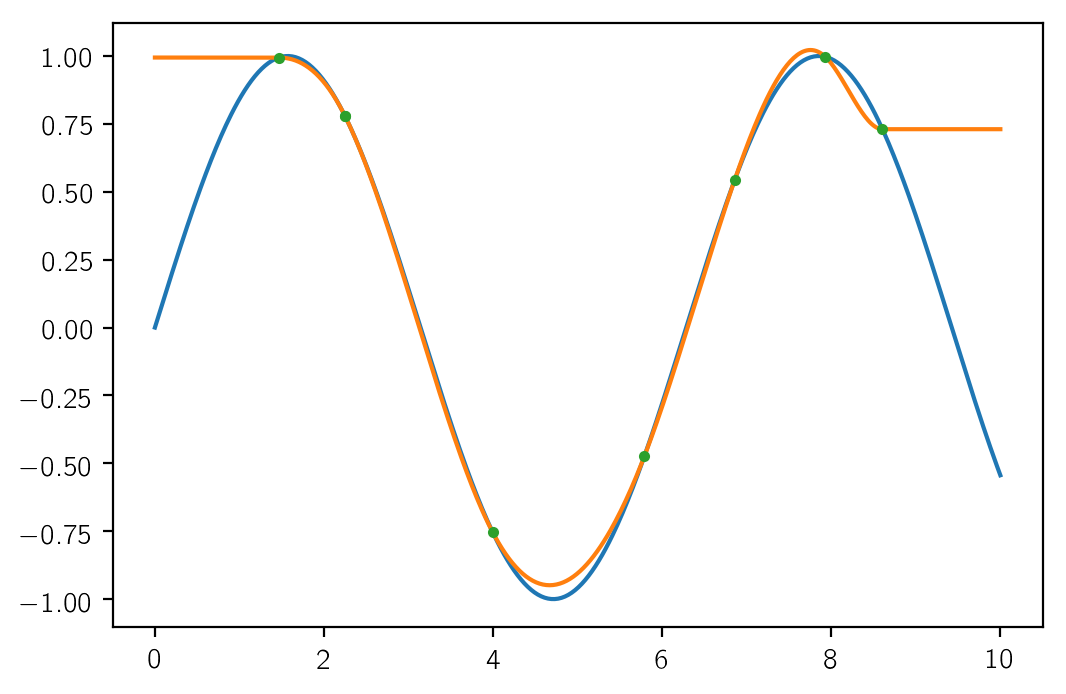

In [74]:
t = np.linspace(0, 10, 500)
m = np.searchsorted(x, t)

xp = np.concatenate((x[:1], x, x[-1:]))
yp = np.concatenate((y[:1], y, y[-1:]))

poly = P[m]
dd = t - xp[m]
value = yp[m] + poly[:, 0] * dd + poly[:, 1] * dd**2 + poly[:, 2] * dd**3

plt.plot(t, np.sin(t))
plt.plot(t, value)
plt.plot(x, y, ".")

In [77]:
def get_system(dx, dy):
    A = np.diag(np.concatenate((
        2*dx[:1], 2*(dx[1:]+dx[:-1]), 2*dx[-1:]
    )))
    A += np.diag(dx, k=1)
    A += np.diag(dx, k=-1)
    
    Y = np.concatenate((
        3 * dy[:1]/dx[:1],
        3 * (dy[1:]/dx[1:] - dy[:-1]/dx[1:]),
        -3 * dy[:1]/dx[:1],
    ))
    
    return A, Y

In [79]:
A, Y = get_system(dx, dy)

In [82]:
c = np.linalg.solve(A, Y)
c

array([-1.42204185e+03,  2.84303232e+03, -1.25764318e+00,  6.96400213e-01,
        1.68232759e-01, -1.32734338e-01, -1.09803477e+00,  1.15785694e+00])

In [96]:
bc = np.random.randn(len(c))
Ax = np.linalg.solve(A, bc)
bA = -Ax[:, None] * c[None, :]

In [97]:
bA

array([[-1.72646474e+03,  3.45165305e+03, -1.52687252e+00,
         8.45481740e-01,  2.04247103e-01, -1.61149375e-01,
        -1.33309601e+00,  1.40572459e+00],
       [ 1.04163516e+03, -2.08250020e+03,  9.21214353e-01,
        -5.10108017e-01, -1.23229254e-01,  9.72269228e-02,
         8.04302365e-01, -8.48121665e-01],
       [ 3.19562343e+02, -6.38888422e+02,  2.82618549e-01,
        -1.56495594e-01, -3.78053956e-02,  2.98281629e-02,
         2.46751222e-01, -2.60194507e-01],
       [-3.86081683e+01,  7.71877921e+01, -3.41447756e-02,
         1.89071346e-02,  4.56748771e-03, -3.60371226e-03,
        -2.98114371e-02,  3.14355978e-02],
       [-2.31600837e+01,  4.63030443e+01, -2.04826050e-02,
         1.13419217e-02,  2.73992273e-03, -2.16177771e-03,
        -1.78831426e-02,  1.88574364e-02],
       [ 3.48971942e+01, -6.97685876e+01,  3.08628178e-02,
        -1.70898019e-02, -4.12846589e-03,  3.25732746e-03,
         2.69459950e-02, -2.84140432e-02],
       [-5.15015599e+02,  1.029650

In [103]:
print(np.allclose(np.diag(bA), -Ax*c))
print(np.allclose(np.diag(bA, k=1), -Ax[:-1]*c[1:]))
print(np.allclose(np.diag(bA, k=-1), -Ax[1:]*c[:-1]))

True
True
True


In [94]:
eps = 1e-5

A[1, 0] += eps
r = np.linalg.solve(A, Y)
vp = np.sum(r * bc)

A[1, 0] -= 2*eps
r = np.linalg.solve(A, Y)
vm = np.sum(r * bc)
A[1, 0] += eps

est = 0.5 * (vp - vm) / eps
print(est, bA[1, 0], est - bA[1, 0])

2605.0918704640935 2605.0918704401956 2.3897882783785462e-08
